<a href="https://colab.research.google.com/github/pavlo-seimskyi/filler-sound-detector/blob/build-training-data/notebooks/3-train-first-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torch -U
!pip install torchaudio -U
!pip3 install pickle5

In [ ]:
import torchaudio
import torch
import os
import shutil
import pickle5 as pickle
from sklearn.model_selection import train_test_split
import torchaudio.functional as F

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

In [ ]:
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [ ]:
# What GPU am I using?
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
CUTOFF_THRES = 0.8

# Read processed data from gDrive

In [ ]:
# Source
GDRIVE_FOLDER = "drive/MyDrive/data-science/filler-sound-detector/data"
FEATURES_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "features")
TARGETS_SRC_FOLDER = os.path.join(GDRIVE_FOLDER, "targets")

# Destination
FEATURES_PATH = "data/features"
TARGETS_PATH = "data/targets"

In [ ]:
feature_files = os.listdir(FEATURES_SRC_FOLDER)
target_files = os.listdir(TARGETS_SRC_FOLDER)

In [ ]:
os.makedirs(FEATURES_PATH, exist_ok=True)
os.makedirs(TARGETS_PATH, exist_ok=True)

In [ ]:
for features, targets in zip(feature_files, target_files):
  features_src = os.path.join(FEATURES_SRC_FOLDER, features)
  features_dst = os.path.join(FEATURES_PATH, features)

  targets_src = os.path.join(TARGETS_SRC_FOLDER, targets)
  targets_dst = os.path.join(TARGETS_PATH, targets)
  shutil.copy(src=features_src, dst=features_dst)
  shutil.copy(src=targets_src, dst=targets_dst)

---

# Read data

In [ ]:
def read_pickle(path):
  with open(path, 'rb') as handle:
      return pickle.load(handle)

In [ ]:
def convert_target_to_binary(y, threshold):
  out = y.clone()
  out[out >= threshold] = 1
  out[out < threshold] = 0
  return out

In [ ]:
x = torch.tensor([])
y = torch.tensor([])

for speaker_filename in os.listdir(FEATURES_PATH):
  current_x = read_pickle(f"{FEATURES_PATH}/{speaker_filename}")
  current_y = read_pickle(f"{TARGETS_PATH}/{speaker_filename}")

  x = torch.concat((x, current_x), dim=1)
  y = torch.concat((y, current_y), dim=0)

---

# Train model

### Prepare data for training

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
  x.transpose(0, 1),
  convert_target_to_binary(y, threshold=CUTOFF_THRES), 
  test_size=0.33, 
  random_state=42,
)

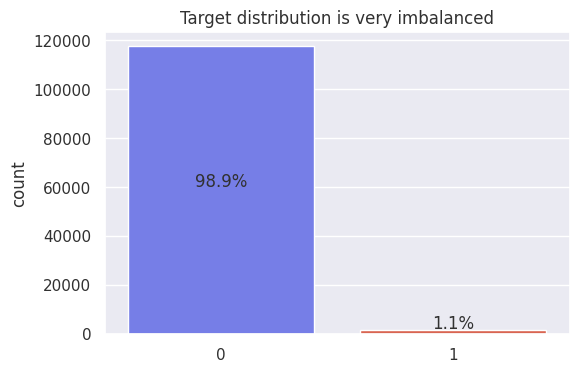

In [ ]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.numpy().astype(int), ax=ax)

# show the mean
for p in ax.patches:
  h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
  xy_ = (x_ + w_ / 2., h_ / 2)
  pct = 100 * h_ / y_valid.shape[0]
  text = f'{pct:0.1f}%'
  ax.annotate(s=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is very imbalanced")
plt.show()

---

### Define the model

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):
  def __init__(self, n_features, n_hidden, n_classes, batch_size=64):
    super().__init__()
    self.batch_size = batch_size
    self.in_layer = torch.nn.Linear(n_features, n_hidden)
    self.mid_layer = torch.nn.Linear(n_hidden, n_hidden)
    self.out_layer = torch.nn.Linear(n_hidden, n_classes)
    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax()

  def forward(self, x):
    # flatten?
    out = self.in_layer(x)
    out = self.relu(out)
    out = self.mid_layer(out)
    out = self.relu(out)
    out = self.out_layer(out)
    return self.softmax(out)

In [ ]:
N_FEATURES = x_train.shape[1]
N_HIDDEN = 128

In [ ]:
model = MultiLayerPerceptron(
  n_features=N_FEATURES, 
  n_hidden=N_HIDDEN, 
  n_classes=2,
)

---

### Train

Train using [this guide](https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md).

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(0, 5):
  

---

### Evaluate

In [ ]:
def evaluate(y_test, y_pred_proba):
  print_metrics(y_test, y_pred_proba)
  y_pred = convert_target_to_binary(y_pred_proba, threshold=CUTOFF_THRES)

  y_test = y_test.cpu().numpy()
  y_pred_proba = y_pred_proba.cpu().numpy()
  y_pred = y_pred.cpu().numpy()

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
  plt.tight_layout(h_pad=1, w_pad=9)
  plot_confusion_matrix(y_test, y_pred, ax=axs[0])
  plot_precision_recall_curve(y_test, y_pred_proba, threshold=0.5, ax=axs[1])

In [ ]:
def print_metrics(y_test, y_pred_proba, threshold=0.5):
  y_pred = convert_target_to_binary(y_pred_proba, threshold=0.5)
  
  metrics = {
      "f1": f1_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred),
      "recall": recall_score(y_test, y_pred),
      "avg_precision_score": average_precision_score(y_test, y_pred_proba)
  }
  
  print(", ".join([f"{name}: {round(value, 3)}" for name, value in metrics.items()]))

In [ ]:
def plot_precision_recall_curve(y_test, y_pred_proba, threshold, ax):
  """Plot the curve with a marker pointing to the current cutoff threshold.
  :param y_test: true target variable
  :param y_pred_proba: prediction probabilities for the positive class (0.0 to 1.0)
  :param threshold: cutoff point to determine the final prediction
  :param ax: matplotlib.plt axis
  :return: None
  """
  PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
  ax.set_title("Precision-recall curve")
  y_pred = (y_pred_proba >= threshold).astype(float)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  ax.plot(
      recall,
      precision,
      marker="x",
      color="r",
      markersize=15,
      label="chosen threshold",
  )
  ax.legend()

In [ ]:
def plot_confusion_matrix(y_test, y_pred, ax):
  """
  Plot a confusion matrix on axis.
  :param y_test: true target variable
  :param y_pred: predictions
  :param ax: matplotlib.plt axis
  :return: None
  """
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
  ax.grid(False)
  ax.set_title("Confusion matrix")

In [ ]:
y_pred = y_valid.clone()

f1: 1.0, precision: 1.0, recall: 1.0, avg_precision_score: 1.0


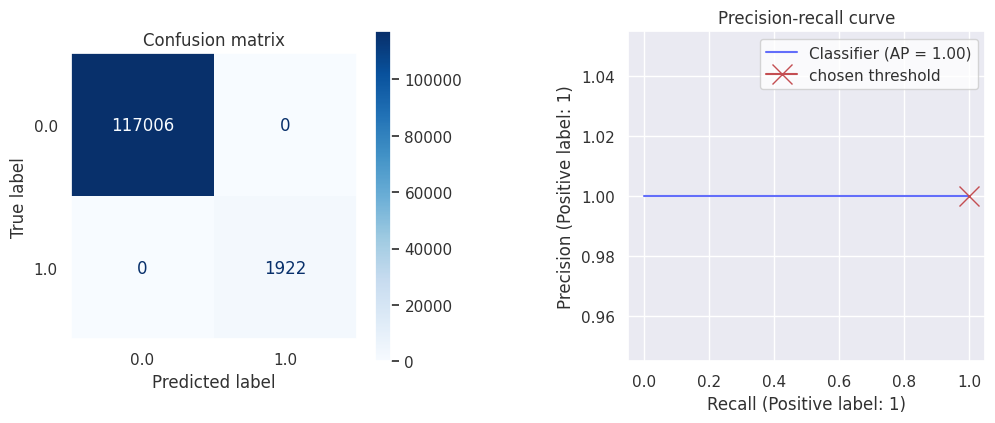

In [ ]:
evaluate(y_valid, y_pred)

---